In [202]:
#importer les packages
import os
import pickle
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.callbacks import EarlyStopping
from datetime import datetime, timedelta



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [203]:
#dataset
data=pd.read_excel('/content/dataset (2).xlsx')
data

,Text,Label
0,Let's have a meeting on 05/07 to discuss about...,0
1,Can we have a meeting at 5:00 PM?,0
2,I'd like to set up an online meeting to review...,0
3,"We're organizing a workshop on Monday, 06/10, ...",0
4,"Can we have a conference call on Thursday, 07/...",0
...,...,...
1205,I'm double-booked on our charity event plannin...,3
1206,would like to reschedule our workshop to ensur...,3
1207,"I'm sorry, but I need to reschedule our one-on...",3
1208,There's a clash with the end-of-year report re...,3


In [204]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1210 entries, 0 to 1209
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    1210 non-null   object
 1   Label   1210 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 19.0+ KB


In [205]:

cat_data=[]
num_data=[]
for i,c in enumerate(data.dtypes):
  if c==object:
    cat_data.append(data.iloc[:,i])
  else:
    num_data.append(data.iloc[:,i])
cat_data=pd.DataFrame(cat_data).transpose()
num_data=pd.DataFrame(num_data).transpose()


In [206]:
num_data

,Label
0,0
1,0
2,0
3,0
4,0
...,...
1205,3
1206,3
1207,3
1208,3


In [207]:
cat_data=cat_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
cat_data.isnull().sum().any()


False

In [208]:
cat_data['Text'].value_counts()

Text
I'm unable to rearrange my schedule, so I won't be able to attend.    5
I've circled the date and will show up ready for action.              4
I'm primed for our meeting and will be there as planned.              4
I'll be part of the meeting—no ifs, ands, or buts about it.           4
I'm confirming my attendance as eagerly as one awaits a sunrise.      4
                                                                     ..
Yes, the time works for me, I'll join the call.                       1
Absolutely, I'll be in attendance.                                    1
Consider it confirmed; I'll be there.                                 1
Yes, I have noted the date and will attend.                           1
Ok, see you then.                                                     1
Name: count, Length: 891, dtype: int64

In [209]:
le=LabelEncoder()
for i in cat_data:
  cat_data[i]=le.fit_transform(cat_data[i])
cat_data

,Text
0,638
1,66
2,419
3,854
4,65
...,...
1205,494
1206,889
1207,527
1208,766


In [210]:
X=pd.concat([cat_data,num_data], axis=1)
y=data['Label']

In [211]:
y

0       0
1       0
2       0
3       0
4       0
       ..
1205    3
1206    3
1207    3
1208    3
1209    1
Name: Label, Length: 1210, dtype: int64

In [212]:
X

,Text,Label
0,638,0
1,66,0
2,419,0
3,854,0
4,65,0
...,...,...
1205,494,3
1206,889,3
1207,527,3
1208,766,3


In [213]:
#on commence par la variable y(chofna kol label 9adeh t3awdet mn marra )
data['Label'].value_counts()

Label
1    376
0    300
3    281
2    253
Name: count, dtype: int64

<ipython-input-214-5392a2148ebe>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_percentages, palette='viridis')


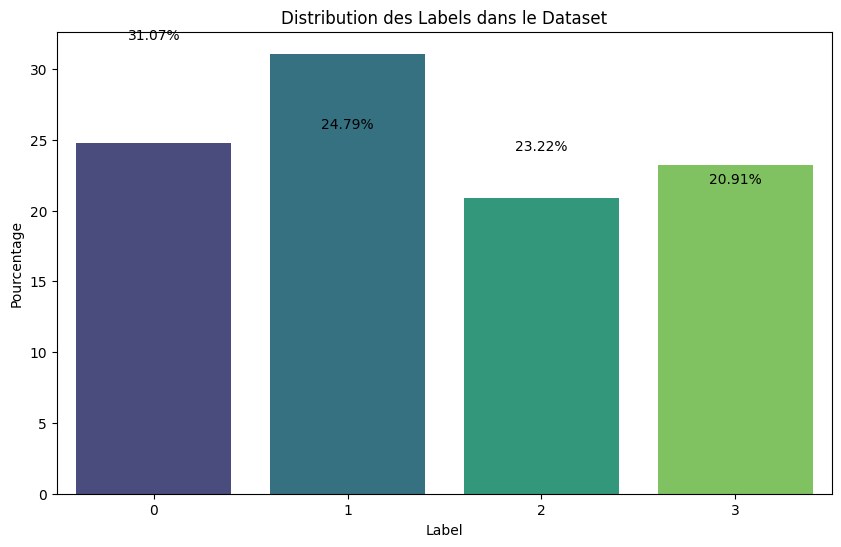

In [214]:
# Assurez-vous que les colonnes 'Text' et 'Label' existent
if 'Text' not in data.columns or 'Label' not in data.columns:
    print("Les colonnes 'Text' et/ou 'Label' n'existent pas dans le DataFrame.")
else:
    # Calculer les pourcentages des labels
    label_counts = data['Label'].value_counts()
    label_percentages = (label_counts / label_counts.sum()) * 100

    # Afficher une figure de notre dataset
    plt.figure(figsize=(10, 6))

    # Créer un graphique à barres
    sns.barplot(x=label_counts.index, y=label_percentages, palette='viridis')

    # Ajouter des labels de pourcentage au-dessus des barres
    for i, percentage in enumerate(label_percentages):
        plt.text(i, percentage + 1, f'{percentage:.2f}%', ha='center')

    # Ajouter des labels et un titre
    plt.xlabel('Label')
    plt.ylabel('Pourcentage')
    plt.title('Distribution des Labels dans le Dataset')
    # Afficher le graphique
    plt.show()


In [215]:

# Ensure you have the required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove non-alphabetic characters (keeping spaces and letters)
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Optional: Remove single-character tokens (which might be useless)
    tokens = [word for word in tokens if len(word) > 1]

    # Join tokens back into a single string with spaces
    return ' '.join(tokens)

# Apply preprocessing to the dataset
data['cleaned_Text'] = data['Text'].apply(preprocess_text)
print(data[['Text', 'cleaned_Text']])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                   Text  \
0     Let's have a meeting on 05/07 to discuss about...   
1                     Can we have a meeting at 5:00 PM?   
2     I'd like to set up an online meeting to review...   
3     We're organizing a workshop on Monday, 06/10, ...   
4     Can we have a conference call on Thursday, 07/...   
...                                                 ...   
1205  I'm double-booked on our charity event plannin...   
1206  would like to reschedule our workshop to ensur...   
1207  I'm sorry, but I need to reschedule our one-on...   
1208  There's a clash with the end-of-year report re...   
1209                                  Ok, see you then.   

                                           cleaned_Text  
0                           let meeting discus progress  
1                                            meeting pm  
2     id like set online meeting review agenda next ...  
3       organizing workshop monday pm would like attend  
4

In [216]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(data['cleaned_Text']).toarray()

y = data['Label']

In [217]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('X_train :', X_train.shape)
print('X_test :', X_test.shape)
print('y_train :', y_train.shape)
print('y_test :', y_test.shape)

X_train : (968, 964)
X_test : (242, 964)
y_train : (968,)
y_test : (242,)


In [218]:


# Define models dictionary including MultinomialNB
models = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegression': LogisticRegression(random_state=42)

}

# Define the accuracy function
def accu(y_true, y_pred, retu=False):
    acc = accuracy_score(y_true, y_pred)
    if retu:
        return acc
    else:
        print(f'Model Accuracy : {acc}')

# Define the train_test_eval function
def train_test_eval(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        print(name, ':')
        model.fit(X_train, y_train)
        accu(y_test, model.predict(X_test))
        print('-' * 30)

# Evaluate models
train_test_eval(models, X_train, y_train, X_test, y_test)


KNeighborsClassifier :
Model Accuracy : 0.9421487603305785
------------------------------
LogisticRegression :
Model Accuracy : 0.9586776859504132
------------------------------


In [219]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [220]:
with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)

In [221]:

with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)